# IMPORTS AND HARDWARE

In [1]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 30.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.1 MB/s eta 0:00:00
  Created wheel for labelme: filename=labelme-5.4.1-py3-none-any.whl size=1436184 sha256=0e8596f81be26756d173ce770c8f4842a56326f411aaf4a79154dac5c4f7a53c
  Stored in directory: /root/.cache/pip/whe

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import cv2
import time
import json
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score
import os
import re
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# DATASET LOADING

In [5]:
#Pulling all image paths
images_links = tf.data.Dataset.list_files("/content/drive/MyDrive/cs231n_project/16_frame_imgs/*.jpg",shuffle = False)

In [6]:
#Preparing Label Dictionary
with open('/content/drive/MyDrive/cs231n_project/16_fram_imgs.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [7]:
images_array_mask1 = np.array(list(images_links.as_numpy_iterator()))

# Create a boolean mask to filter out repeated images
mask = np.array([str(val)[-6] != ')' for val in images_array_mask1])
# Apply the mask to images array
images_array_mask1 = images_array_mask1[mask]




In [8]:
labels_array = []
imagesFinal = []

#Creating image-label parallel arrays
for image in images_array_mask1:
  imagesFinal.append(image)
  #Isolating image ID
  s = str(image)
  last_slash_index = s.rfind('/')
  new_string = s[last_slash_index + 1:-1]

  labels_array.append(data[new_string])

images_array_mask2 = np.array(imagesFinal)

In [9]:
numVids = int(images_array_mask2.shape[0]/16)
print("NUM VIDS", numVids)
images_array = images_array_mask2.reshape(numVids,16)
images_final = []
for frames in images_array:
  frame_numbers = [int(str(file_name)[int(str(file_name).rfind('frame'))+5:int(str(file_name).rfind('.'))]) for file_name in frames]


  # Sort the frame numbers and use the sorted indices to reorder the rows of the array
  sorted_indices = np.argsort(frame_numbers)
  images_final.append(frames[sorted_indices])

images_array = np.array(images_final).reshape(numVids*16,)
print(images_array)


NUM VIDS 825
[b'/content/drive/MyDrive/cs231n_project/16_frame_imgs/aaqaifqrwn_frame0.jpg'
 b'/content/drive/MyDrive/cs231n_project/16_frame_imgs/aaqaifqrwn_frame1.jpg'
 b'/content/drive/MyDrive/cs231n_project/16_frame_imgs/aaqaifqrwn_frame2.jpg'
 ...
 b'/content/drive/MyDrive/cs231n_project/16_frame_imgs/zzmgnglanj_frame13.jpg'
 b'/content/drive/MyDrive/cs231n_project/16_frame_imgs/zzmgnglanj_frame14.jpg'
 b'/content/drive/MyDrive/cs231n_project/16_frame_imgs/zzmgnglanj_frame15.jpg']


## Dataset Preprocessing

In [10]:
#Converts file path into image
def load_image(x):
    sizeTup = (int(1080*(1/10)),int(1920*(1/10)))
    #reading in file name
    byte_img = tf.io.read_file(x)
    #converting to img array
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,sizeTup)
    img = img/255
    return img

In [11]:
@tf.function
def preprocessData(x):
  sizeTup = (int(1080*(1/10)),int(1920*(1/10)))
  x = tf.data.Dataset.from_tensor_slices(x)
  xProcessed = x.map(preprocess_sequence)
  return x

def preprocess_sequence(file_paths):
    print(file_paths)
    sizeTup = (int(1080*(1/10)),int(1920*(1/10)))
    f#ile_paths = tf.data.Dataset.from_tensor_slices(file_paths)
    images = file_paths.map(load_image)
    print(images)
    return images

def preprocess_images(x):
  sizeTup = (int(1080*(1/10)),int(1920*(1/10)))
  images = load_image(x)
  images = tf.image.resize(images,sizeTup)
  images = images/255
  return images

In [12]:
spatialX = tf.data.Dataset.from_tensor_slices(images_array)
spatialX = spatialX.map(preprocess_images)
spatialX = spatialX.batch(16)
print(spatialX)
spatialY = np.array(labels_array).reshape(numVids,16)
spatialYList = spatialY[:, 0].flatten()
print(spatialYList.shape)
spatialY = tf.data.Dataset.from_tensor_slices(spatialYList)
print(spatialY)

<_BatchDataset element_spec=TensorSpec(shape=(None, 108, 192, None), dtype=tf.float32, name=None)>
(825,)
<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [13]:
combined_dataset = tf.data.Dataset.zip((spatialX,spatialY))

#print("X",XData)
print("COMBINED",combined_dataset)

buffer_size = 1000  # Buffer size for shuffling
train_size = int(0.8 * len(combined_dataset))
val_size = test_size = int(0.1 * len(combined_dataset))

# Shuffle the combined dataset
combined_dataset = combined_dataset.shuffle(buffer_size)
train_dataset = combined_dataset.take(train_size).batch(16).prefetch(4)
remaining_dataset = combined_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size).batch(16).prefetch(4)
test_dataset = remaining_dataset.skip(val_size).batch(16).prefetch(4)
print(combined_dataset)
print(train_dataset)
print(val_dataset)
print(test_dataset)




COMBINED <_ZipDataset element_spec=(TensorSpec(shape=(None, 108, 192, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 108, 192, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 108, 192, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 108, 192, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 108, 192, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
print("Train Len: ", len(y_train), "Train Non_Zeros: ", np.count_nonzero(y_train))
print("Test Len: ", len(y_test), "Test Non_Zeros: ", np.count_nonzero(y_test))
print("Val Len: ", len(y_dev), "Val Non_Zeros: ", np.count_nonzero(y_dev))


Train Len:  10560 Train Non_Zeros:  3434
Test Len:  1320 Test Non_Zeros:  394
Val Len:  1320 Val Non_Zeros:  412


# DATA VIZUALISER

TypeError: Invalid shape (108, 192, 2) for image data

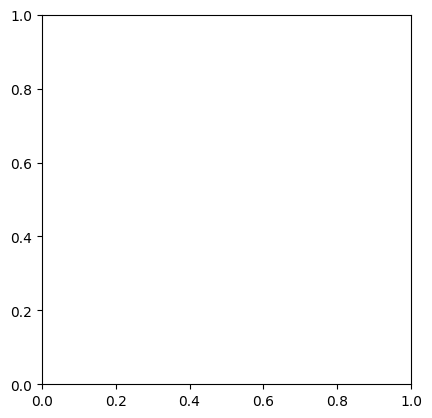

In [ ]:
#Vizualzing
image_generator = temporalX.as_numpy_iterator()
batch = image_generator.next()
count = 0
for image in batch:
  plt.imshow(image)
  plt.axis("off")
  plt.show()
  count+=1

In [ ]:
print(image.shape)

(216, 384, 3)


#MODEL ResNet50 Spatial Features

## Building Model

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,ResNet50V2
from tensorflow.keras.layers import Input,Dense, GlobalAveragePooling2D,Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Reshape, LSTM,Dropout, TimeDistributed
from tensorflow.keras.models import Model

def spatial_stream():
  # Input layer for the sequence of frames
  spatial_shape = (int(1080*(1/10)), int(1920*(1/10)), 3)
  input_shape = (16, ) + spatial_shape
  input_layer = Input(shape=input_shape)

  # Pretrained ResNet50 model for spatial feature extraction
  base_cnn = ResNet50(weights='imagenet', include_top=False, input_shape=spatial_shape)
  for layer in base_cnn.layers:
      layer.trainable = False

  # Extract spatial features for each frame
  cnn_output = TimeDistributed(base_cnn)(input_layer)
  cnn_output = TimeDistributed(GlobalAveragePooling2D())(cnn_output)

  # Dense layers after CNN feature extraction
  cnn_output = TimeDistributed(Dense(1024, activation='relu'))(cnn_output)
  cnn_output = TimeDistributed(Dense(512, activation='relu'))(cnn_output)
  cnn_output = TimeDistributed(Dense(512, activation='relu'))(cnn_output)

  # Temporal RNN
  rnn_output = LSTM(512, return_sequences=True)(cnn_output)
  rnn_output = LSTM(512)(rnn_output)

  # Fully connected layers with dropout
  x = Dense(1024, activation='relu')(rnn_output)
  x = Dropout(0.5)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.5)(x)

  # Output layer
  output = Dense(1, activation='sigmoid')(x)

  model = Model(input_layer, output)
  return model




In [15]:
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_loss(alpha=0.5):
    def loss(y_true, y_pred):
        bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)

        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())

        f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        pr_loss = 1 - f1_score

        return alpha * bce_loss + (1 - alpha) * pr_loss

    return loss

In [16]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train = spatialYList  # Replace with your actual labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [19]:
model_res = spatial_stream()
model_res.compile(optimizer='adam', loss=custom_loss(0.5), metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_res.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 16, 108, 192, 3   0         
                             )]                                  
                                                                 
 time_distributed_10 (TimeD  (None, 16, 4, 6, 2048)    23587712  
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 16, 2048)          0         
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, 16, 1024)          2098176   
 istributed)                                                     
                                                                 
 time_distributed_13 (TimeD  (None, 16, 512)           5248

## Res Training

In [ ]:
for i in range(5):
  sample = next(iter(train_dataset))
  print(sample[0].shape)
  break

AttributeError: '_VariantDataset' object has no attribute 'shape'

In [20]:
history_res = model_res.fit(train_dataset, epochs=10, validation_data=val_dataset,class_weight = class_weights)

Epoch 1/10
42/42 [==============================] - 687s 1s/step - loss: 0.7214 - accuracy: 0.4924 - precision_2: 0.3133 - recall_2: 0.4929 - val_loss: 0.6348 - val_accuracy: 0.2805 - val_precision_2: 0.2805 - val_recall_2: 1.0000
Epoch 2/10
42/42 [==============================] - 91s 1s/step - loss: 0.6954 - accuracy: 0.5045 - precision_2: 0.3313 - recall_2: 0.5116 - val_loss: 0.6768 - val_accuracy: 0.2927 - val_precision_2: 0.2927 - val_recall_2: 1.0000
Epoch 3/10
42/42 [==============================] - 92s 1s/step - loss: 0.7107 - accuracy: 0.5091 - precision_2: 0.2894 - recall_2: 0.3780 - val_loss: 0.6316 - val_accuracy: 0.2927 - val_precision_2: 0.2927 - val_recall_2: 1.0000
Epoch 4/10
42/42 [==============================] - 91s 1s/step - loss: 0.6517 - accuracy: 0.4379 - precision_2: 0.3208 - recall_2: 0.6284 - val_loss: 0.8458 - val_accuracy: 0.7317 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/10
42/42 [==============================] - 90s 1s/step - loss:

In [21]:
model_res.save("/content/drive/MyDrive/cs231n_project/resmodel_rnn_v3.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_res.save("resmodel_rnn_v2.keras")

In [23]:
history_res_dict = history_res.history
json.dump(history_res_dict, open("training_history_rnn_v3", 'w'))

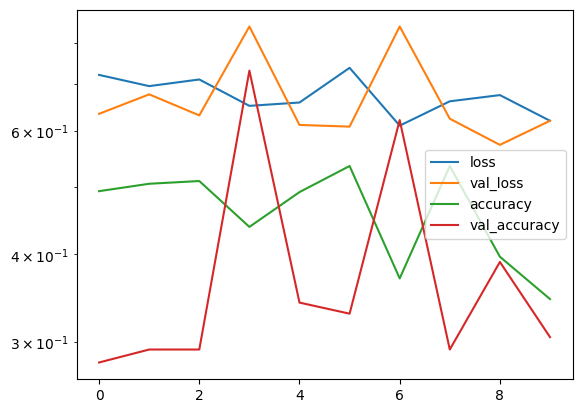

In [24]:
history_res_df = pd.DataFrame(history_res_dict)

plt.plot(history_res_df['loss'], label='loss')
plt.plot(history_res_df['val_loss'], label='val_loss')
plt.plot(history_res_df['accuracy'], label='accuracy')
plt.plot(history_res_df['val_accuracy'], label='val_accuracy')

plt.yscale('log')
plt.legend()
plt.show()


## Res Testing

In [ ]:
model_res = tf.keras.models.load_model("/content/drive/MyDrive/CS131_Proj/Res_20_Epochs_model.h5")

OSError: No file or directory found at /content/drive/MyDrive/CS131_Proj/Res_20_Epochs_model.h5

In [ ]:
model_res.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 216, 384, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 512)               262656

In [26]:
data = model_res.evaluate(test_dataset)
print(data)

6/6 [==============================] - 39s 253ms/step - loss: 0.5844 - accuracy: 0.3614 - precision_2: 0.3614 - recall_2: 1.0000
[0.5843948721885681, 0.3614457845687866, 0.3614457845687866, 1.0]


In [ ]:
X_test = test_dataset.map(lambda x, y: x)
y_test = test_dataset.map(lambda x, y: y)
#Baseline Continous Predictions
predicted_test_res = model_res.predict(X_test)
print(predicted_test_res)

4/4 [==============================] - 30s 225ms/step


In [ ]:
#Changing continuous into binary predictions
predicted_test_res_binary = np.where(predicted_test_res > 0.5, 1.0, 0.0)
print(predicted_test_res.shape)
print(predicted_test_res_binary)

(60, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [ ]:
#Getting Res Accuracy and Precision score:

res_test_accuracy = accuracy_score(y_test, predicted_test_res_binary)
res_test_precision = precision_score(yArr, predicted_test_res_binary)
res_test_recall = recall_score(yArr, predicted_test_res_binary)

print("Res test Accuracy: ",res_test_accuracy)
print("Res test Precision: ",res_test_precision)
print("Res test Recall: ",res_test_recall)

ValueError: Found input variables with inconsistent numbers of samples: [4, 60]

In [ ]:
print("Total Predicted Labels: ", len(predicted_test_res_binary), "Predicted \"real\" images: ", np.count_nonzero(predicted_test_res_binary))
print("Total Actual Labels: ", len(yArr), "Actual \"real\" images: ", np.count_nonzero(yArr))

Total Predicted Labels:  515 Predicted "real" images:  121
Total Actual Labels:  515 Actual "real" images:  175


In [ ]:
np.savetxt('predicted_labels_face.txt', predicted_test_res)
np.savetxt('correct_labels_face.txt', yArr)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## VIDEO LOADER

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

#change if you want a diff number of frames per vid
NUM_FRAMES = 16

def extract_frames(video_path, num_frames=NUM_FRAMES):
    #print(video_path)
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    #print(total_frames)
    frames_step = total_frames // num_frames
    frames = []
    for i in range(num_frames):
        video.set(cv2.CAP_PROP_POS_FRAMES, i*frames_step)
        success, frame = video.read()
        if success:
            frames.append(frame)
    video.release()
    return frames

def preprocess_frame(frame):
    # change frame to a tensor
    frame_tensor = tf.convert_to_tensor(frame, dtype=tf.float32)
    # resize to a fifth of the size
    size_tuple = (int(1080*(1/5)), int(1920*(1/5)))
    resized_frame = tf.image.resize(frame_tensor, size_tuple)
    #normalize
    normalized_frame = resized_frame / 255.0
    return normalized_frame

def predict_frames(frames,model):
    predictions = []
    for frame in frames:
        processed_frame = preprocess_frame(frame)
        prediction = model.predict(np.expand_dims(processed_frame, axis=0))
        predictions.append(prediction)
    #print(predictions)
    return predictions

def is_deepfake(predictions, threshold=0.8):
    # Assuming the model outputs a probability of being real
    fake_count = sum(pred > 0.5 for pred in predictions)
    # If the majority of frames are real, the video is considered not a deepfake
    return fake_count >= threshold*len(predictions)  # If not, it's considered a deepfake
#usage below
def is_deepfakeVideo(path,model):
    video_path = path
    #model_path = 'resmodel.h5'

    frames = extract_frames(video_path)
    #print(len(frames))
    predictions = predict_frames(frames, model)
    result = is_deepfake(predictions)
    return result


In [ ]:
with open('/content/drive/MyDrive/CS131_Proj/test_videos/metadata.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
labels = data.values()

In [ ]:
def read_json(path, real_only=False):
    with open(path, 'r') as file:
        data = json.load(file)
        if real_only:
            return {mp4_file: 0 for mp4_file, details in data.items() if details['label'] == 'REAL'}
        else:
            return {mp4_file: 1 if details['label'] == 'FAKE' else 1 for mp4_file, details in data.items()}

In [ ]:
path = '/content/drive/MyDrive/CS131_Proj/test_videos/metadata.json'
data = read_json(path)
labels = data.values()

In [ ]:
videoPaths = tf.data.Dataset.list_files("/content/drive/MyDrive/CS131_Proj/test_videos/*.mp4",shuffle = False)
video_paths_array = np.array(list(videoPaths.as_numpy_iterator()), dtype=str)
videoPred = []
count = 1
for path in video_paths_array:
  if count > 30:
    break
  result = is_deepfakeVideo(path,model_res)
  print("DONE: ",count)
  videoPred.append(result)
  count+=1
videoPred_arr = np.array(videoPred)

1/1 [==============================] - 0s 22ms/step
DONE:  1
1/1 [==============================] - 0s 22ms/step
DONE:  2
1/1 [==============================] - 0s 21ms/step
DONE:  3
1/1 [==============================] - 0s 21ms/step
DONE:  4
1/1 [==============================] - 0s 20ms/step
DONE:  5
1/1 [==============================] - 0s 21ms/step
DONE:  6
1/1 [==============================] - 0s 20ms/step
DONE:  7
1/1 [==============================] - 0s 20ms/step
DONE:  8
1/1 [==============================] - 0s 20ms/step
DONE:  9
1/1 [==============================] - 0s 20ms/step
DONE:  10
1/1 [==============================] - 0s 20ms/step
DONE:  11
1/1 [==============================] - 0s 20ms/step
DONE:  12
1/1 [==============================] - 0s 22ms/step
DONE:  13
1/1 [==============================] - 0s 21ms/step
DONE:  14
1/1 [==============================] - 0s 21ms/step
DONE:  15
1/1 [==============================] - 0s 21ms/step
DONE:  16
1/1 [============

In [ ]:
yArr = list(labels)[0:30]
yArr = np.array(yArr)
print(videoPred_arr)
print(yArr)

NameError: name 'videoPred_arr' is not defined

In [ ]:
vid_test_accuracy = accuracy_score(yArr, videoPred_arr)
vid_test_precision = precision_score(yArr, videoPred_arr)
vid_test_recall = recall_score(yArr, videoPred_arr)

print("Vid test Accuracy: ",vid_test_accuracy)
print("Vid test Precision: ",vid_test_precision)
print("Vid test Recall: ",vid_test_recall)

Vid test Accuracy:  0.6
Vid test Precision:  0.1111111111111111
Vid test Recall:  0.2
